## Import data from Kaggle

We are using the "US Used cars dataset" from "https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset/data"

In [59]:
import os 
import kaggle

In [60]:
kaggleDataset = "ananaymital/us-used-cars-dataset"
datasetPath = os.path.join("dataset", "Used Cars")

In [61]:
kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset


In [62]:
import pandas as pd 

def loadCarData(datasetPath=datasetPath):
    csvPath = os.path.join(datasetPath, "used_cars_data.csv")
    return pd.read_csv(csvPath, nrows=20000, low_memory=False)

## Examine quick info about the data structure

In [63]:
carsLoad = loadCarData()
carsLoad = carsLoad[carsLoad["price"] > 0]
carsLoad.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [64]:
carsLoad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   vin                      20000 non-null  object 
 1   back_legroom             18807 non-null  object 
 2   bed                      187 non-null    object 
 3   bed_height               1396 non-null   object 
 4   bed_length               1396 non-null   object 
 5   body_type                19922 non-null  object 
 6   cabin                    191 non-null    object 
 7   city                     20000 non-null  object 
 8   city_fuel_economy        16836 non-null  float64
 9   combine_fuel_economy     0 non-null      float64
 10  daysonmarket             20000 non-null  int64  
 11  dealer_zip               20000 non-null  int64  
 12  description              19574 non-null  object 
 13  engine_cylinders         19366 non-null  object 
 14  engine_displacement   

In [65]:
carsLoad.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,16836.000000,0.0,20000.00000,20000.000000,18708.000000,16836.000000,18708.000000,0.0,20000.000000,2.000000e+04,20000.000000,19456.000000,12152.000000,2.000000e+04,20000.000000,19967.000000,20000.000000,0.0,20000.000000
mean,21.933595,NaN,72.36315,15311.145950,2824.369254,28.964540,245.911268,NaN,41.028732,2.756730e+08,-75.367854,37172.220189,1.473338,2.902654e+04,808.549800,4.021543,259198.065450,NaN,2017.094550
std,7.684504,NaN,100.69591,14827.988247,1118.224506,7.109211,86.023567,NaN,1.776646,8.158635e+06,3.771266,48720.257390,0.871242,2.274686e+04,1318.081124,0.604308,121868.637539,NaN,4.076143
min,10.000000,NaN,0.00000,922.000000,700.000000,13.000000,78.000000,NaN,18.346700,9.873062e+07,-118.449000,0.000000,1.000000,7.950000e+02,0.000000,1.000000,49848.000000,NaN,1950.000000
25%,18.000000,NaN,15.00000,7203.000000,2000.000000,25.000000,178.000000,NaN,40.733300,2.750598e+08,-74.474100,10.000000,1.000000,1.699500e+04,0.000000,3.593023,158236.000000,NaN,2017.000000
50%,21.000000,NaN,36.00000,8876.000000,2500.000000,28.000000,241.000000,NaN,40.862200,2.784062e+08,-74.049300,22013.000000,1.000000,2.587700e+04,184.500000,4.142857,282642.000000,NaN,2018.000000
75%,24.000000,NaN,75.00000,11716.000000,3500.000000,32.000000,295.000000,NaN,41.420800,2.802355e+08,-73.528600,48387.500000,2.000000,3.680000e+04,1212.000000,4.555556,342815.000000,NaN,2020.000000
max,127.000000,NaN,2150.00000,91401.000000,8100.000000,122.000000,808.000000,NaN,43.037200,2.816678e+08,-66.078500,341893.000000,10.000000,1.390000e+06,32718.000000,5.000000,439503.000000,NaN,2021.000000


Let's make our dataset only with the columns that are not filled with many null values, and if it is a bit we can replace the few null values with "No Input".

Let's also combine make and model columns to one column, and convert some obvious numeric objects to float types.

In [66]:
cars = carsLoad.loc[:, ["body_type", "city", "daysonmarket", "engine_displacement", "engine_type", "exterior_color", "franchise_dealer", "fuel_type", "horsepower", 'interior_color', "is_new", "latitude", "listed_date", "listing_color", "listing_id", "longitude", "make_name", "model_name", "mileage", "price", "savings_amount", "seller_rating", "transmission", "trim_name", "wheel_system", "year"]]

for col in ['body_type', 'engine_type', 'exterior_color', 'interior_color', 'fuel_type', 'transmission', 'trim_name', 'wheel_system']:
    cars[col] = cars[col].fillna('No Input').str.lower()

cars["make_model"] = carsLoad['make_name'] + ' ' + carsLoad['model_name']

for col in ['front_legroom', 'maximum_seating']:
    cars[col] = carsLoad[col].str.extract(r'(\d+(?:\.\d+)?)').astype(float)
    
for col in ['listed_date']:
    cars['listed_dateTEMP'] = pd.to_datetime(carsLoad[col]) 
    cars[col] = cars['listed_dateTEMP'].astype('int64') / 1e9
    
for col in ['make_name', 'model_name', 'listed_dateTEMP']:
    cars.drop(col, axis=1, inplace=True)

In [67]:
cars.head()

,body_type,city,daysonmarket,engine_displacement,engine_type,exterior_color,franchise_dealer,fuel_type,horsepower,interior_color,...,price,savings_amount,seller_rating,transmission,trim_name,wheel_system,year,make_model,front_legroom,maximum_seating
0,suv / crossover,Bayamon,522,1300.0,i4,solar yellow,True,gasoline,177.0,black,...,23141.0,0,2.8,a,latitude fwd,fwd,2019,Jeep Renegade,41.2,5.0
1,suv / crossover,San Juan,207,2000.0,i4,narvik black,True,gasoline,246.0,black (ebony),...,46500.0,0,3.0,a,s awd,awd,2020,Land Rover Discovery Sport,39.1,7.0
2,sedan,Guaynabo,1233,2500.0,h4,no input,True,gasoline,305.0,no input,...,46995.0,0,NaN,m,base,awd,2016,Subaru WRX STI,43.3,5.0
3,suv / crossover,San Juan,196,3000.0,v6,eiger gray,True,gasoline,340.0,gray (ebony/ebony/ebony),...,67430.0,0,3.0,a,v6 hse awd,awd,2020,Land Rover Discovery,39.0,7.0
4,suv / crossover,San Juan,137,2000.0,i4,narvik black,True,gasoline,246.0,black (ebony),...,48880.0,0,3.0,a,s awd,awd,2020,Land Rover Discovery Sport,39.1,7.0


In [68]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_type            20000 non-null  object 
 1   city                 20000 non-null  object 
 2   daysonmarket         20000 non-null  int64  
 3   engine_displacement  18708 non-null  float64
 4   engine_type          20000 non-null  object 
 5   exterior_color       20000 non-null  object 
 6   franchise_dealer     20000 non-null  bool   
 7   fuel_type            20000 non-null  object 
 8   horsepower           18708 non-null  float64
 9   interior_color       20000 non-null  object 
 10  is_new               20000 non-null  bool   
 11  latitude             20000 non-null  float64
 12  listed_date          20000 non-null  float64
 13  listing_color        20000 non-null  object 
 14  listing_id           20000 non-null  int64  
 15  longitude            20000 non-null 

Let's make a new column grouping "price", this will come in handy later to ensure our test set is not running into sampling bias. 

In [69]:
import numpy as np

cars["priceGroup"] = pd.cut(cars["price"],
                            bins=[0., 10000., 20000.,30000., 40000., 50000., np.inf],
                            labels=[1, 2, 3, 4, 5, 6])

<Axes: >

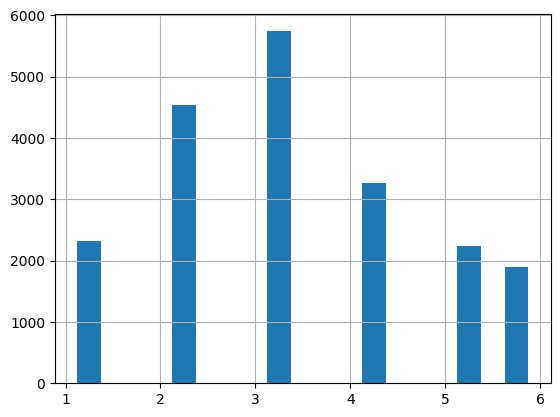

In [70]:
cars["priceGroup"].hist(rwidth=0.5)

In [71]:
cars["priceGroup"].value_counts() / len(cars)

priceGroup
3    0.28700
2    0.22725
4    0.16355
1    0.11620
5    0.11155
6    0.09445
Name: count, dtype: float64

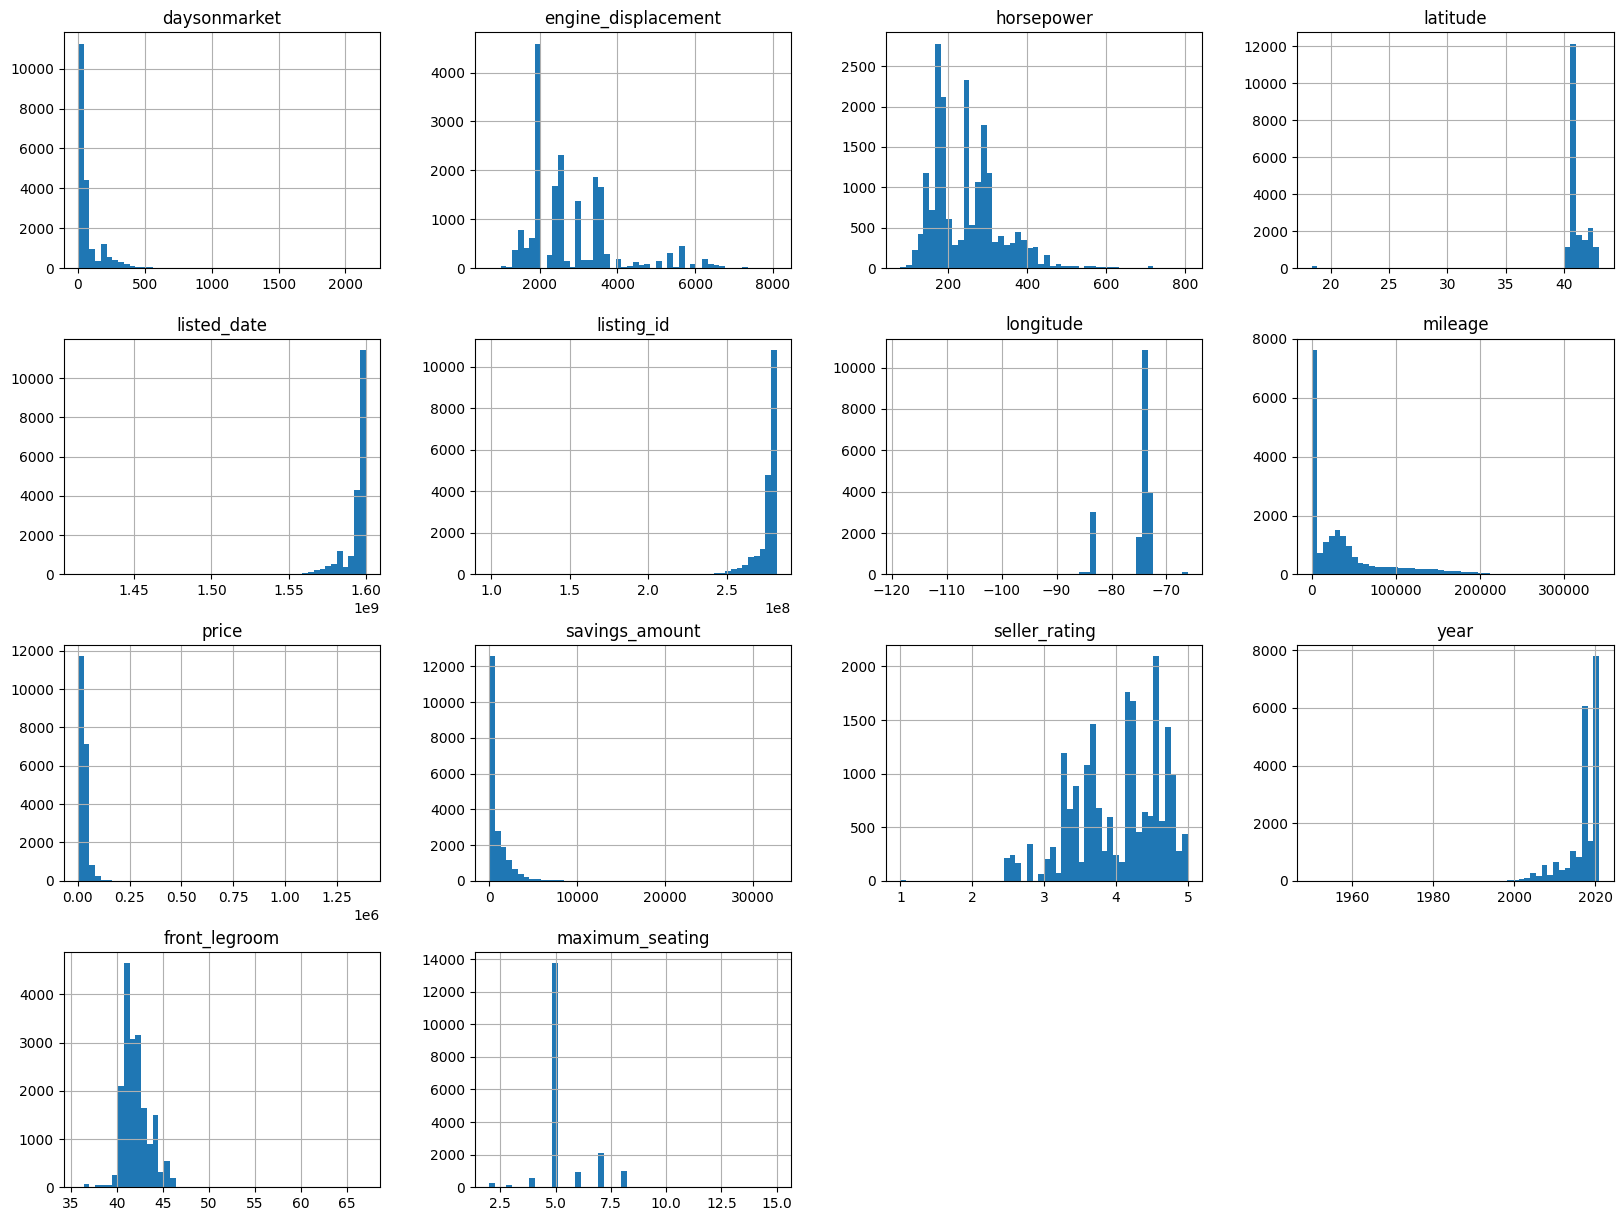

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

cars.hist(bins=50, figsize=(20,15))
plt.show()

## Set a side a test set, before changing anything on the data structure

In order to ensure that our test set stays consistent no matter how many times we rerun the program or update the dataset, we want to use a unique identifier to help us decide if the row should go into the test set or not. We can compute a hash for each row's unique identifier and if it is less than or equal to 20% of the maximum hash value, it will go into the test set. 

In [73]:
len(cars) - len(cars["listing_id"].unique()) # Making sure "listing_id" is unique

0

In [74]:
from zlib import crc32

def IDTest(ID, testRatio):
    return crc32(np.int64(ID)) & 0xffffffff < testRatio*2**32

def splitTrainTestByID(dataset,testRatio,ID):
    IDs = dataset[ID]
    testRows = IDs.apply(lambda ID_: IDTest(ID_, testRatio))
    return dataset.loc[~testRows], dataset.loc[testRows]

In [75]:
trainSet, testSet = splitTrainTestByID(cars, 0.2, "listing_id")

In [76]:
len(trainSet) / len(cars) # training set should be 80%

0.8005

In [77]:
len(testSet) / len(cars) # training set should be 20%

0.1995

Let's compare our test set's price group proportions to the overall price group proportions.

In [78]:
(testSet["priceGroup"].value_counts() / len(testSet)) - (cars["priceGroup"].value_counts() / len(cars))


priceGroup
3    0.000469
2   -0.000433
4   -0.001144
1   -0.000912
5    0.000731
6    0.001289
Name: count, dtype: float64

The proportions of the price groups in our test set are nearly identical to the overall proportions, with the largest difference being 0.32% off. 
Therefore, it is not necessary to try and do stratified sampling. 

We can now be confident that our test set is a good representation of the overall dataset.
We can remove the priceGroup column.

In [79]:
for set_ in (trainSet, testSet):
    set_ = set_.drop("priceGroup", axis=1)

## Now we can play with our train set, first let's start with visualizing the data

In [80]:
cars = trainSet.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

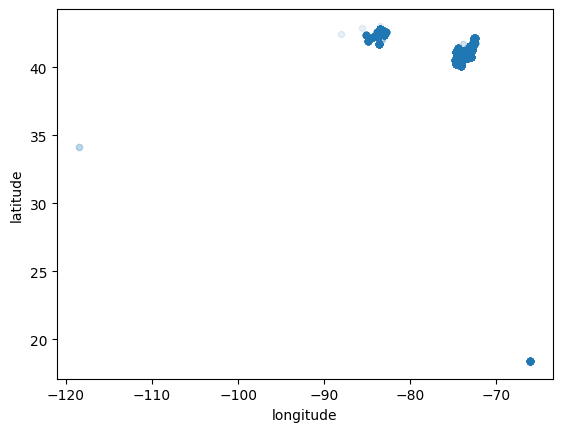

In [81]:
cars.plot.scatter(x="longitude", y="latitude", alpha=0.1)

<Axes: xlabel='mileage', ylabel='daysonmarket'>

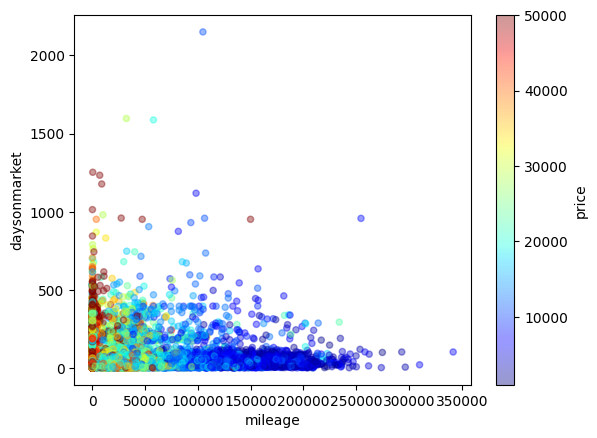

In [82]:
cars.plot.scatter(x="mileage", y="daysonmarket", alpha=0.4,
                  c="price", cmap=plt.get_cmap("jet"), colorbar=True,
                  vmin=1000, vmax=50000)

In [83]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16010 entries, 0 to 19998
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   body_type            16010 non-null  object  
 1   city                 16010 non-null  object  
 2   daysonmarket         16010 non-null  int64   
 3   engine_displacement  14978 non-null  float64 
 4   engine_type          16010 non-null  object  
 5   exterior_color       16010 non-null  object  
 6   franchise_dealer     16010 non-null  bool    
 7   fuel_type            16010 non-null  object  
 8   horsepower           14978 non-null  float64 
 9   interior_color       16010 non-null  object  
 10  is_new               16010 non-null  bool    
 11  latitude             16010 non-null  float64 
 12  listed_date          16010 non-null  float64 
 13  listing_color        16010 non-null  object  
 14  listing_id           16010 non-null  int64   
 15  longitude            160

Let's start looking at correlations and visualize it.

In [84]:
cars_numeric = cars.select_dtypes(include=['float64', 'int64'])
corr_matrix = cars_numeric.corr()

In [85]:
corr_matrix["price"].sort_values(ascending=False)

price                  1.000000
horsepower             0.599128
year                   0.464928
engine_displacement    0.236730
daysonmarket           0.118108
seller_rating          0.111469
maximum_seating        0.058208
longitude             -0.015335
savings_amount        -0.019948
front_legroom         -0.037056
latitude              -0.104405
listing_id            -0.115502
listed_date           -0.118075
mileage               -0.502558
Name: price, dtype: float64

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='horsepower', ylabel='price'>,
        <Axes: xlabel='year', ylabel='price'>,
        <Axes: xlabel='mileage', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='horsepower'>,
        <Axes: xlabel='horsepower', ylabel='horsepower'>,
        <Axes: xlabel='year', ylabel='horsepower'>,
        <Axes: xlabel='mileage', ylabel='horsepower'>],
       [<Axes: xlabel='price', ylabel='year'>,
        <Axes: xlabel='horsepower', ylabel='year'>,
        <Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='mileage', ylabel='year'>],
       [<Axes: xlabel='price', ylabel='mileage'>,
        <Axes: xlabel='horsepower', ylabel='mileage'>,
        <Axes: xlabel='year', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>]], dtype=object)

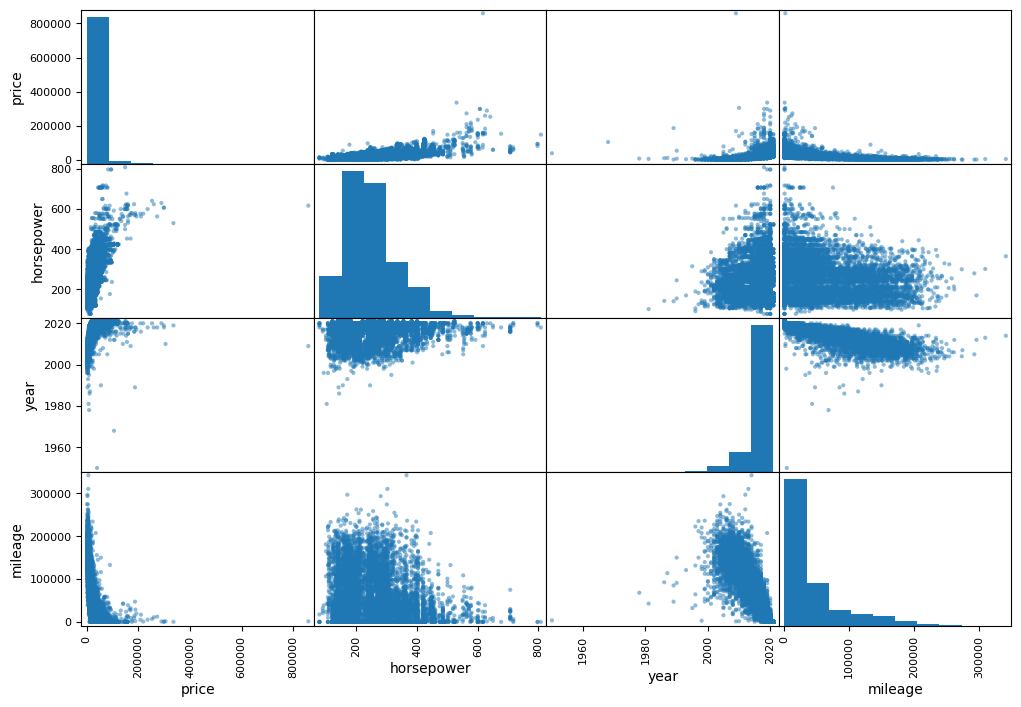

In [86]:
from pandas.plotting import scatter_matrix

attributes = ["price", "horsepower", "year", "mileage"]
scatter_matrix(cars[attributes], figsize=(12,8))

For our transfomation pipeline, we will need it to do some data cleaning. Some of our float type columns still have some null values. We can replace all null values with the median of the attribute.

To be on the safer side, let's use Scikit-Learn's SimpleImputer class to replace all null values with the median to all numerical columns. Let's see how it will do before creating our pipeline.

In [87]:
cars = trainSet.drop("price", axis=1)
carsLabels = trainSet["price"].copy()

In [88]:
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy="median")

cars_numeric = cars.select_dtypes(include=['float64', 'int64'])
imputer.fit(cars_numeric)

SimpleImputer(strategy='median')

In [89]:
imputer.statistics_

array([ 3.60000000e+01,  2.50000000e+03,  2.41000000e+02,  4.08622000e+01,
        1.59649920e+09,  2.78406164e+08, -7.40493000e+01,  2.19790000e+04,
        1.90000000e+02,  4.14285714e+00,  2.01800000e+03,  4.18000000e+01,
        5.00000000e+00])

In [90]:
cars_numeric.median().values

array([ 3.60000000e+01,  2.50000000e+03,  2.41000000e+02,  4.08622000e+01,
        1.59649920e+09,  2.78406164e+08, -7.40493000e+01,  2.19790000e+04,
        1.90000000e+02,  4.14285714e+00,  2.01800000e+03,  4.18000000e+01,
        5.00000000e+00])

In our pipeline, we want to change the bool columns, "is_new" and "franchise_dealer", to a numeric value using OrdinalEncoder. Let's see how it works.

In [91]:
from sklearn.preprocessing import OrdinalEncoder 

# cars_bool = cars[["is_new", "franchise_dealer"]]
cars_bool = cars.select_dtypes(include=['bool'])
ordinal_encoder = OrdinalEncoder()
cars_bool_encoded = ordinal_encoder.fit_transform(cars_bool)
cars_bool_encoded[:10]

array([[1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 0.]])

For our pipeline, we also want to change the categorical columns to a numeric value. For this we can use OneHotEncoder. Let's see how it is.

In [92]:
from sklearn.preprocessing import OneHotEncoder

# cars_object = cars[["body_type", "city", "engine_type", "exterior_color", "fuel_type", "interior_color", "listed_date", "listing_color", "transmission", "trim_name", "wheel_system", "make_model"]]
cars_object = cars.select_dtypes(include=['object'])
object_encoder = OneHotEncoder()
cars_object_1hot = object_encoder.fit_transform(cars_object)
cars_object_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 176110 stored elements and shape (16010, 5564)>

In [93]:
cars_object_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
object_encoder.categories_

[array(['convertible', 'coupe', 'hatchback', 'minivan', 'no input',
        'pickup truck', 'sedan', 'suv / crossover', 'van', 'wagon'],
       dtype=object),
 array(['Ann Arbor', 'Antioch', 'Auburn Hills', 'Avenel', 'Battle Creek',
        'Bay Shore', 'Bayamon', 'Berlin', 'Bloomfield', 'Bloomingdale',
        'Bohemia', 'Branford', 'Bronx', 'Brooklyn', 'Carlstadt',
        'Center Line', 'Clinton Township', 'Coldwater', 'Copiague',
        'Croton-On-Hudson', 'Danbury', 'Davison', 'Detroit', 'Dover',
        'East Hartford', 'East Meadow', 'East Windsor', 'Elizabeth',
        'Elmhurst', 'Elmont', 'Englewood', 'Fair Lawn', 'Fairview',
        'Flat Rock', 'Flemington', 'Flushing', 'Freeport', 'Garfield',
        'Grand Rapids', 'Great Neck', 'Green Brook', 'Greenwich',
        'Guaynabo', 'Hasbrouck Heights', 'Hempstead', 'Hicksville',
        'Highland', 'Holly', 'Howell', 'Huntington', 'Irvington',
        'Islip Terrace', 'Jamaica', 'Jersey City', 'Kenvil', 'Lakewood',
        'La

Now we can start building our transformation pipelines.

Let's make a numerical pipeline first for our numeric columns. We will replace all null values with the median values, and also use StandardScaler() to scale all columns.

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cars_numeric_tr = numeric_pipeline.fit_transform(cars_numeric)

Now we can make our full pipeline, where we use the numeric_pipeline for our numerical columns, Ordinalencoder() for our bool columns, and OneHotEncoder() for our object columns. 

In [96]:
from sklearn.compose import ColumnTransformer

numeric_attribs = list(cars_numeric)
bool_attribs = list(cars_bool)
object_attribs = list(cars_object)

full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_attribs),
    ('bool', OrdinalEncoder(), bool_attribs),
    ('objects', OneHotEncoder(handle_unknown='ignore'), object_attribs), 
])

cars_prepared = full_pipeline.fit_transform(cars)

We now have prepared our training set for training. 

## Selecting and Training a Model

We will first try to train the model using a Linear Regression Model.

In [97]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(cars_prepared, carsLabels)

LinearRegression()

We can just see how it does with some data from the training set itself.

In [98]:
some_data = cars.iloc[:5]
some_labels = carsLabels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [25616.64835624 46493.80278384 52743.87481159 67428.05399485
 67792.86501795]
Labels: [23141.0, 46500.0, 46995.0, 67430.0, 66903.0]


In [99]:
from sklearn.metrics import mean_squared_error

cars_predictions = lin_reg.predict(cars_prepared)
lin_mse = mean_squared_error(carsLabels, cars_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(2730.4665083523278)

Let's evaluate our models using Scikit-Learn's K-fold cross-validation, doing 10 folds. 

In [100]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, cars_prepared, carsLabels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [101]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores:  [ 7673.17825534 14116.09088496  8673.40870743 11550.24934688
  8646.91968779 11113.94441035  4417.1921286  11597.14293346
 28394.4220488  18777.88410671]
Mean:  12496.043251031297
Standard deviation: 6453.010318054852


Let's do the same for using Decision Tree Regression

In [102]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(cars_prepared, carsLabels)

DecisionTreeRegressor()

In [103]:
cars_predictions = tree_reg.predict(cars_prepared)
tree_mse = mean_squared_error(carsLabels, cars_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(31.719166076122605)

In [104]:
tree_scores = cross_val_score(tree_reg, cars_prepared, carsLabels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores:  [ 8529.28582526  8369.45271957  8977.24772056  8102.05570424
  8123.31312358  4811.93576922  4587.52804225  7146.5054149
 27050.96183895 21125.72574193]
Mean:  10682.40119004524
Standard deviation: 6980.01079228332


Now with Random Forest Regression

In [105]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(cars_prepared, carsLabels)

RandomForestRegressor()

In [106]:
cars_predictions = forest_reg.predict(cars_prepared)
forest_mse = mean_squared_error(carsLabels, cars_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(2844.7259331452174)

In [107]:
forest_scores = cross_val_score(forest_reg, cars_prepared, carsLabels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [ 6699.6969312   6002.91004547  5947.98171904  5709.54986777
  5084.780232    3813.84926182  3507.87053764  5397.70557555
 26355.05376142  7886.58609286]
Mean:  7640.59840247869
Standard deviation: 6354.044311172613


In [108]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'n_estimators': [3,10,30],'max_depth':[2,4,6,8,10],'min_samples_leaf': [1,2,4], 'max_features': [2,4,6,8,10]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,4,6,8,10]},
]

forest_reg = RandomForestRegressor()

Randomized_search = RandomizedSearchCV(forest_reg, param_grid, n_iter=100, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           refit=True,
                           return_train_score=True)

Randomized_search.fit(cars_prepared, carsLabels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions=[{'max_depth': [2, 4, 6, 8, 10],
                                         'max_features': [2, 4, 6, 8, 10],
                                         'min_samples_leaf': [1, 2, 4],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 4, 6, 8, 10],
                                         'n_estimators': [3, 10]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [109]:
Randomized_search.best_params_

{'n_estimators': 10, 'max_features': 2, 'bootstrap': False}

In [110]:
Randomized_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=10)

In [111]:
cvres = Randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

20680.493628322507 {'n_estimators': 10, 'min_samples_leaf': 2, 'max_features': 8, 'max_depth': 4}
20401.599705687393 {'n_estimators': 10, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 4}
20745.935975835135 {'n_estimators': 3, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 8}
20773.756560390608 {'n_estimators': 10, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 4}
15588.387000538416 {'n_estimators': 3, 'max_features': 10, 'bootstrap': False}
20477.0166524647 {'n_estimators': 10, 'min_samples_leaf': 4, 'max_features': 10, 'max_depth': 6}
20777.780790541165 {'n_estimators': 3, 'min_samples_leaf': 4, 'max_features': 10, 'max_depth': 2}
20557.649725467323 {'n_estimators': 30, 'min_samples_leaf': 4, 'max_features': 8, 'max_depth': 10}
20510.459597447138 {'n_estimators': 30, 'min_samples_leaf': 4, 'max_features': 8, 'max_depth': 6}
20646.741402525753 {'n_estimators': 30, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 6}
20448.713322575073 {'n_estimators': 10,

In [112]:
feature_importances = Randomized_search.best_estimator_.feature_importances_
feature_importances

array([2.76660590e-02, 2.68466167e-02, 5.06363623e-02, ...,
       4.84352666e-06, 7.19640965e-04, 3.35627822e-05])

In [113]:
len(feature_importances)

5579

In [114]:
object_encoder = full_pipeline.named_transformers_["objects"]
object_one_hot_attribs = np.concatenate(object_encoder.categories_)
object_attribs = list(object_one_hot_attribs)
attributes = numeric_attribs + bool_attribs + object_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.05063636234412676), 'horsepower'),
 (np.float64(0.04243630871441002), 'year'),
 (np.float64(0.04122427168905453), 'mileage'),
 (np.float64(0.030625491130759585), 'savings_amount'),
 (np.float64(0.028243609681727795), 'front_legroom'),
 (np.float64(0.027666059012752313), 'daysonmarket'),
 (np.float64(0.026846616713825044), 'engine_displacement'),
 (np.float64(0.023797434317484184), 'listing_id'),
 (np.float64(0.023506789288809306), 'listed_date'),
 (np.float64(0.019951108904819312), 'franchise_dealer'),
 (np.float64(0.018232070447627053), 'seller_rating'),
 (np.float64(0.01648273616784749), 'rosso energia'),
 (np.float64(0.014549226963144849), 'is_new'),
 (np.float64(0.013016564705610714), 'longitude'),
 (np.float64(0.01092848693241844), 'latitude'),
 (np.float64(0.010440246048962445), 'fwd'),
 (np.float64(0.010244607397999747), 'v8'),
 (np.float64(0.010085056776286032), 'maximum_seating'),
 (np.float64(0.009734730062555935), 'UNKNOWN'),
 (np.float64(0.008236761300038548)

In [115]:
FinalModel = Randomized_search.best_estimator_

X_test = testSet.drop("price", axis = 1)
y_test = testSet["price"].copy()

X_test_prepared = full_pipeline.transform(X_test)

finalPredictions = FinalModel.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, finalPredictions)
final_rmse = np.sqrt(final_mse)

In [134]:
np.set_printoptions(threshold=np.inf)
print(finalPredictions)
print(final_rmse)

[ 45779.6    29333.5    66356.3    29718.5    62168.6    27122.4
  12784.4    56478.     22276.9    36202.9    25511.7    18033.8
  21585.8    48028.3    68026.4    65839.9    53669.3    32195.
  18400.8    29645.     20164.6    29135.3    28699.5    63684.7
  32195.     17344.1    54969.5    30808.4    78849.4    26445.8
  32993.1    23550.5    32863.8    65045.7    24144.5    38738.
  22365.5    29095.6    24758.7    30104.6    24842.8    21201.
  19359.1    26459.6    55886.3    45337.3    20358.3    13724.8
  31574.2    17264.2    24886.8    23592.4    18171.5    20455.9
  12382.4    25907.3    10661.7    16057.     25597.6    28153.4
  20677.7     7214.4    13370.5    31596.     14998.6    19050.7
  23045.     22980.9    37894.9    56537.     22130.6    21869.6
  33471.8    17504.5    42621.8    19796.3    20826.5    25186.9
  21394.9    21984.     20224.4    29411.     16815.     34427.2
  24615.2    43659.8    28926.8    20336.2    21984.     23652.3
  17525.2    27000.2    3144

In [137]:
from scipy import stats

confidence = 0.95

squared_errors = (finalPredictions - y_test) ** 2
print(squared_errors.tolist())

[9612480.16000001, 31792682.25, 325539023.2899999, 36282552.25, 45298284.16000002, 8279430.760000008, 291168.1600000004, 16641.0, 522873.6099999979, 3916045.2100000056, 4891616.890000003, 26110056.03999999, 6900078.2399999965, 80491400.88999994, 97191993.96000011, 68971364.0099999, 713461494.4899999, 0.0, 6060459.2399999965, 6502500.0, 19718928.35999999, 3745386.089999997, 1958600.25, 2309488.089999991, 0.0, 23465304.809999987, 52063440.25, 3191939.559999995, 348778035.3600002, 80027337.63999999, 307026.80999999837, 2963562.25, 18285886.439999975, 920256.4900000056, 5638250.25, 915849.0, 19101270.25, 37168531.55999998, 9215474.490000004, 29110341.160000015, 128659111.83999999, 75794436.0, 62727984.009999976, 23429472.160000015, 13022715.689999979, 393716869.29000014, 83966066.88999999, 1450097.6400000018, 2721840.0399999977, 409856.0400000009, 149614.23999999944, 5255097.760000006, 58928652.25, 42759828.80999998, 62147995.559999995, 77998924.89000002, 37978871.29000001, 39212644.0, 108

In [138]:
from scipy import stats

confidence = 0.95

squared_errors = (finalPredictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


/var/folders/bj/2340r6hn3zj_p6qymwq6hhlc0000gn/T/ipykernel_1391/1212255870.py:6: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,


array([           nan, 37511.46869967])